# 1 Cross-correlation (8 marks, 4/4)

It has been shown that noise records at two seismic stations, when cross-correlated and stacked,
are very closely associated with the Green's function between these two seismic stations (i.e. given
a delta force at one station, the displacement recorded at the other station). In the class website,
two files are given: one is a vertical component seismogram at PHL (Park Hill) and the other is
a vertical component seismogram at MLAC (Mammoth Lakes). Both are records for one day (24
hours) on February 1, 2003. Sampling rate is dt = 1.0 seconds.

 1. Take the cross-correlation (using FFT) of these seismograms using the record at PHL as $x(t)$
    and that at MLAC as $y(t)$ and plot $C_{xy}(\tau)$. Zoom in your plot between [-260; 260] seconds.
 2. Bit conversion is often used for the cross-correlation Greens function approach. It simply
    changes any positive numbers to 1 and negative numbers to -1 (numpy `sign()` function).
    Apply this to the data at PHL and MLAC and compute their cross-correlation. Compare
    the results against those from the previous step. Does bit-conversion work in this case to
    preserve the phase information of the true cross-correlation? (Note the amplitude of
    bit-converted cross-correlation is of no meaning).

    _Hint_: for discrete cross-correlation using fft:
    - suppose `x = [x0 x1 ... x(N-1)]; y = [y0 y1 ... y(N-1)]`
    - note conv(x,y)=v=[v0 v1 ... v(2N-2)], and notice the relationship between convolution and cross-correlation
    - also note how the fourier transform of the cross-correlation is related to $X(w)^*Y(w)$
    - if we first pad the end of each x and y array with N-1 zeros, convolution theorem suggests that we can interpret the inverse transform of $X^*(w)Y(w)$ as the result of a convolution (length 2N-1), w, interpreted as:  
          w = ifft(...)
            = [w[lag = 0] w[lag = 1 dt] ... w[lag = (N-1) dt] w[lag = -(N-1) dt] ... w[lag = -1 dt]]
    - we then must apply fftshift to center the time shift/lag axis at 0
    - the point of this fft approach is that it's much faster than directly convolving; you can check against  `np.correlate(x, y, mode='same')`
    - "zoom your plot to [-260, 260]" is in reference to the time lag axis in the above process

    _Hint_: you can load the ascii file into Python by `genfromtxt` function:  
        tmp = np.genfromtxt('MLAC_data.txt')  
        mlac = tmp.flatten()

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 1.1

(86400, 86400)
(172799, 172799)


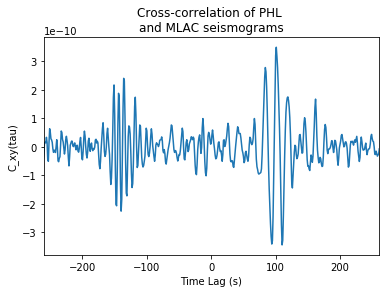

In [115]:
def corr_fft(x, y, dt=1):
    
    

    # padding the arrays with N-1 zeros
    y = np.pad(y, (0,len(y)-1), mode='constant')
    x = np.pad(x, (0,len(x)-1), mode='constant')
    print(len(y), len(x))


    #fourier transforms
    FT_y = np.fft.fft(y)  # dt=1 so no need to multiply by dt
    FT_x = np.fft.fft(x)


    # multiply fourier transforms and then ifft to get the cross-correlation
    W = FT_x*np.conj(FT_y)  # notice that one is the complex conjugate of the fourier transform as per the lecture slides
    w = np.fft.fftshift(np.fft.ifft(W))
    
    # time lag axis
    tau = np.arange(0, len(x), 1) - len(x)//2

    return w, tau



# load data
mlac = np.genfromtxt('MLAC_data.txt').flatten()
phl = np.genfromtxt('PHL_data.txt').flatten()
print(len(mlac), len(phl))

# cross correlation
s = time.time()
w, tau = corr_fft(phl, mlac)
time_fft = time.time()-s

# plotting
plt.plot(tau,w)
plt.xlim([-260,260])
plt.xlabel("Time Lag (s)")
plt.ylabel("C_xy(tau)")
plt.title("Cross-correlation of PHL \nand MLAC seismograms")
plt.show()

(86400, 86400)


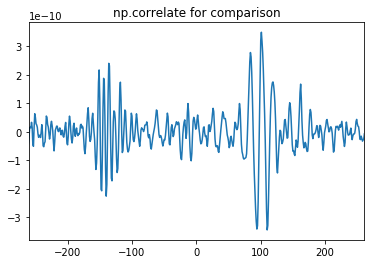

In [116]:
# compare to np.correlate

s = time.time()

mlac = np.genfromtxt('MLAC_data.txt').flatten()
phl = np.genfromtxt('PHL_data.txt').flatten()
print(len(mlac), len(phl))
np_corr = np.correlate(phl, mlac, mode='same')

time_corr = time.time()-s

x = np.arange(0, len(mlac), 1) - len(mlac)//2

plt.plot(x,np_corr)
plt.xlim([-260,260])
plt.title("np.correlate for comparison")
plt.show()

In [117]:
print("Time to do correllation using fft:", time_fft)
print("Time to do correllation using np.correlate:", time_corr)

('Time to do correllation using fft:', 0.23600006103515625)
('Time to do correllation using np.correlate:', 1.116999864578247)


# 1.2

(86400, 86400)
(172799, 172799)


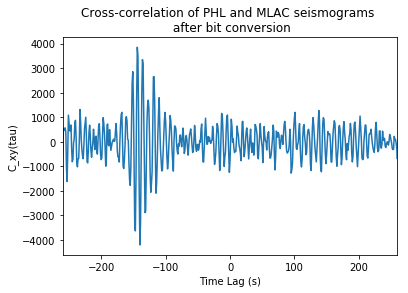

In [118]:
# load data
mlac = np.genfromtxt('MLAC_data.txt').flatten()
phl = np.genfromtxt('PHL_data.txt').flatten()
print(len(mlac), len(phl))

# bit conversion
mlac = np.sign(mlac)
phl = np.sign(phl)

# cross correlation
s = time.time()
w, tau = corr_fft(phl, mlac)
time_fft = time.time()-s

# plotting
plt.plot(tau,w)
plt.xlim([-260,260])
plt.xlabel("Time Lag (s)")
plt.ylabel("C_xy(tau)")
plt.title("Cross-correlation of PHL and MLAC seismograms \n after bit conversion")
plt.show()

The cross-correlation from 1.1 showed that the signals were similar when shifted some amount in either direction, whereas when we apply bit conversion, it only shows that the signals are similar when shifted in one direction. I guess that means bit cinversion does not preserve the phase information, since the signal is probably periodic (or quasi-periodic) so shifting by a certain amounnt in either direction should give something close to the unshifted signal.

# 2 Normal Modes from Long Period Seismometer (7 marks, 1/2/2/1/1)

Background: The solid earth 'rings' like a bell after being struck by a great earthquake. These
are the normal modes associated with internal structures (density and elastic moduli) of the Earth,
and the excitation amplitudes of these modes are determined by the earthquake source mechanism.
The frequencies of these normal modes of oscillation are very low, usually between 0.1 milliHertz
(mHz) and 10 mHz. It is hard to see them above 10 mHz because these higher frequency modes
attenuate quickly, or the frequency spacings are too small to be identified individually. Because
the Earth is a complex structure, with twisting, breathing, and more complex spatial structure in
its modes, the modal frequencies are not simple multiples of a single fundamental as is the case
for a guitar string. They are labelled with a notation (e.g. like $_0S_2$ for spheroidal modes or like
$_1T_8$ for toroidal modes) based on the spherical harmonic spatial distribution that the mode corresponds
to, in the same way that the electron wavefunctions for the Hydrogen atom are labelled. Geophysicists
measure these frequencies because they can be used to invert for models of the Earth's
internal seismic velocity and density structures. With very high-resolution data, one can even see
splitting of these resonances due to the Earth’s rotation and elliptical shape, in a matter analogous
to the Zeeman splitting of atomic spectral lines. You can also optically detect similar phenomenon
('helioseismology') going on in the sun, from which one can also test models of the sun's interior.
(More descriptions can be found on any introductory solid-earth geophysics book).
Here we examine three days of very long period seismic data recorded on the horizontal direction at
station NWAO (Narrogin, Western Australia) after the devastating $M_w = 9.0$, Mar 11th, 2011 Honshu,
Japan earthquake. Data `nwao.vh1` (VH channel, $dt = 10 \text{ sec}$) is given as an ascii
file with two columns: time and velocity (in counts from the digitizer).

 1. Plot the raw data with a time axis in hours.
 2. Plot the power spectrum of your raw data as a function of frequency (in mHz) **without**
    any windowing.
 3. Plot the power spectrum of your raw data after 
     - removing the minor linear trend in the same way as Lab 3, and subsequently 
     - applying a hanning window $w_n = 1 - \cos(2 \pi \frac{n}{N}) ; 0 \leq n \leq N$ (where N is the length of the data file)
 4. Plot on top of each other the power spectra from 2 and 3 between [0.1, 2.6] mHz, and comment on the difference.
 5. Using plt.annotate(...), identify any normal modes you can see. Use the provided modes.pdf (Table 1) to help guide your identification.

# 2.1

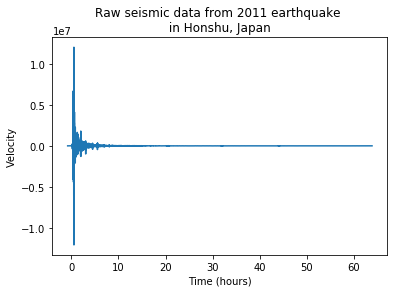

In [119]:
nwao = np.genfromtxt('nwao.vh1').T

dt = 10 # 10 seconds

time = nwao[0]  # in seconds
velocity = nwao[1]

plt.plot(time/(60*60), velocity)  # convert to hours
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.title("Raw seismic data from 2011 earthquake \n in Honshu, Japan ")
plt.show()

# 2.2
Plot the power spectrum of your raw data as a function of frequency (in mHz) without any windowing.

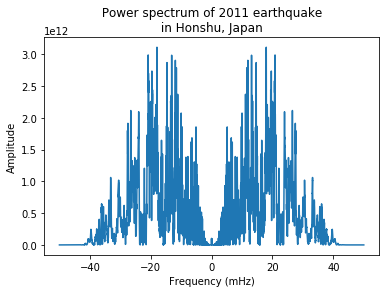

In [120]:
T = time[-1] - time[0]

# fourier transform
FT = np.fft.fft(velocity)*dt

power_spec = FT*np.conj(FT)/T
power_spec = (np.fft.fftshift(power_spec))

# frequency axis:
f = np.fft.fftshift(np.fft.fftfreq(len(velocity), dt))  # in Hz
f = f*1000  # convert to mHz


plt.plot(f, power_spec)
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.title(" Power spectrum of 2011 earthquake \n in Honshu, Japan ")
plt.show()

# 2.3


slope and intercept of linnear trend:
(-3.0251372814690436e-07, 0.046637080330141523)


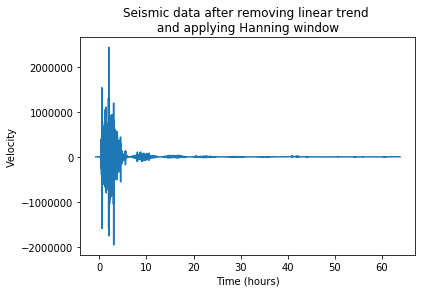

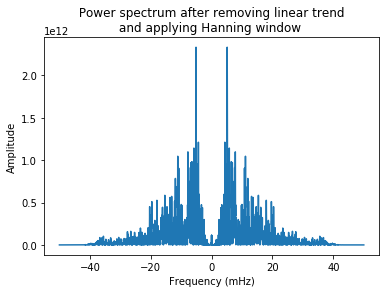

In [121]:
def Hann(t, T):
    return np.where(np.logical_and(t>=0, t<=T), (1 - np.cos((2*np.pi*t)/len(t))), 0) # 0.5

# get trendline
m, b = np.polyfit(time, velocity, 1)
trend = m*time + b
print("slope and intercept of linnear trend:")
print(m, b)

# remove trendline
data = velocity-trend


# apply hanning window
data = data*Hann(time, T)


plt.plot(time/(60*60), data)
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.title("Seismic data after removing linear trend \n and applying Hanning window ")
plt.show()


# Power spectrum
# fourier transform
FT = np.fft.fft(data)*dt

power_spec_hann = FT*np.conj(FT)/T
power_spec_hann = (np.fft.fftshift(power_spec_hann))

# frequency axis:
f = np.fft.fftshift(np.fft.fftfreq(len(data), dt))  # in Hz
f = f*1000  # convert to mHz


plt.plot(f, power_spec_hann)
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.title(" Power spectrum after removing linear trend \n and applying Hanning window  ")
plt.show()


# 2.4

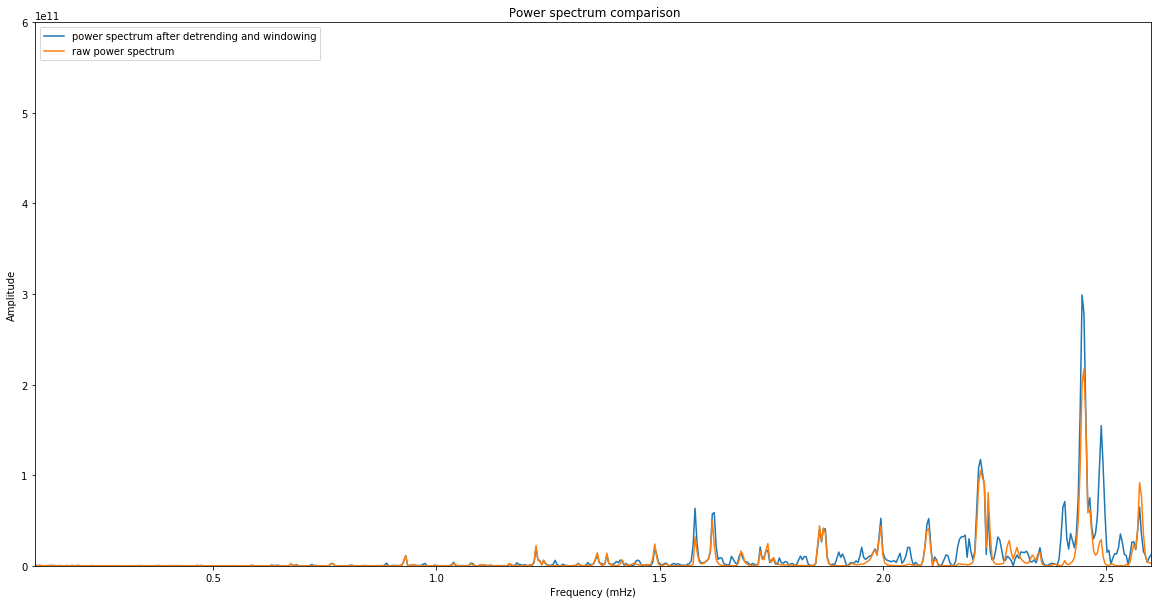

In [122]:
plt.figure(figsize=(20,10))
plt.plot(f, power_spec_hann, label="power spectrum after detrending and windowing")
plt.plot(f, power_spec, label="raw power spectrum")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.title(" Power spectrum comparison")
plt.xlim([0.1, 2.6])
plt.ylim([0,0.6e12])
plt.legend(loc="upper left")
plt.show()

The windowing appears to make some peaks more prominent. For example, looking at the tallest peak, the windowed power spectrum shows a few significant peaks on either side of the tallest peak that do not appear, or at least are much less prominent, in the raw power spectrum.

# 2.5

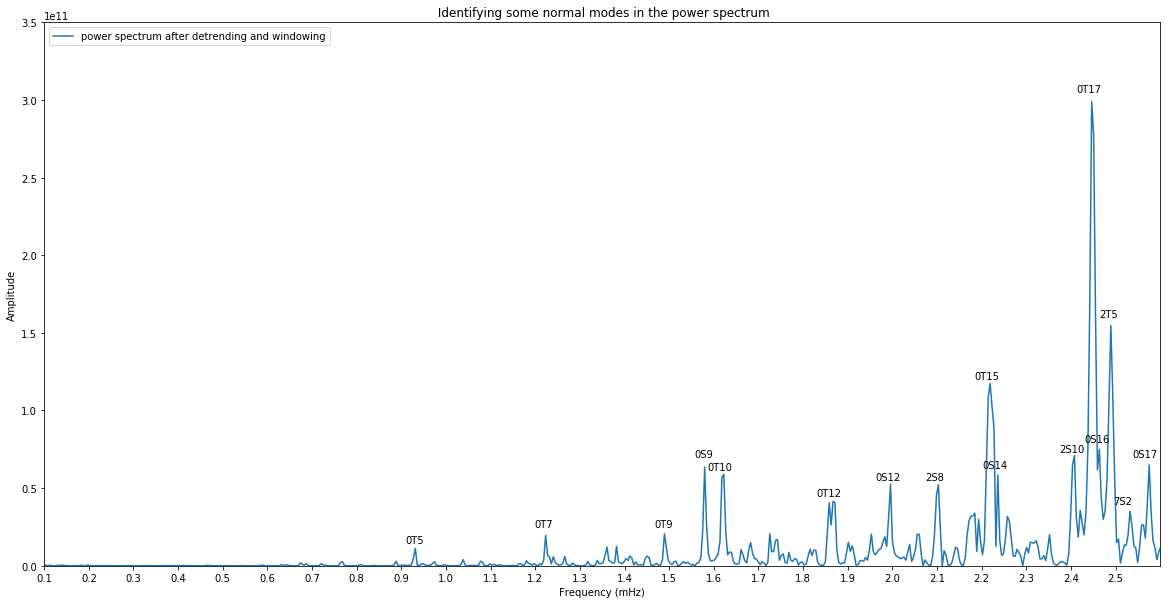

In [124]:
plt.figure(figsize=(20,10))
plt.plot(f, power_spec_hann, label="power spectrum after detrending and windowing")
plt.xlabel("Frequency (mHz)")
plt.ylabel("Amplitude")
plt.title(" Identifying some normal modes in the power spectrum")
plt.xlim([0.1, 2.6])
plt.ylim([0,3.5e11])
plt.legend(loc="upper left")
plt.xticks(np.arange(0.1, 2.6, 0.1))

# annotating
x = [0.93, 1.22, 1.487,1.577, 1.614, 1.858, 1.990, 2.094, 2.212, 2.229, 2.403, 2.441, 2.458, 2.485, 2.517, 2.567]
y = [0.15e11, 0.25e11, 0.25e11, 0.7e11 ,0.62e11 ,0.45e11,0.55e11,0.55e11 ,1.2e11,0.63e11,0.73e11 ,3.05e11,0.8e11 ,1.6e11 ,0.4e11, 0.7e11]
modes = ["0T5", "0T7", "0T9", "0S9", "0T10", "0T12", "0S12", "2S8", "0T15", "0S14", "2S10", "0T17", "0S16", "2T5", "7S2", "0S17"]

for i in range(len(x)):
    plt.annotate(modes[i], (x[i], y[i]), ha="center")
plt.show()